<a href="https://colab.research.google.com/github/Dechrist2021/Mulomba/blob/main/Github_Resilience_projection_classification_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, matthews_corrcoef, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from datetime import datetime
import matplotlib.patches as mpatches
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
from google.colab import files
files.upload()

Saving GlobalWeatherRepository.csv to GlobalWeatherRepository.csv


{'GlobalWeatherRepository.csv': b"country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination\nAfghanistan,Kabul,34.52,69.18,Asia/Kabul,1693301400,2023-08-29 14:00,28.8,83.8,Sunny,7.2,11.5,74,ENE,1004.0,29.64,0.0,0.0,19,0,26.7,80.1,10.0,6.0,7.0,8.3,13.3,647.5,130.2,1.2,0.4,7.9,11.1,1,1,05:24 AM,06:24 PM,05:39 PM,02:48 AM,Waxing Gibbous,93\nAlbania,Tirana,41.33,19.82,Europe/Tirane,1693301400,2023-08-29 11:30,27.0,80.6,Partly cloudy,3.8,6.1,210,SSW,1006.0,29.71,0.

In [ ]:
# Importing the dataset
df = pd.read_csv('GlobalWeatherRepository.csv')

In [ ]:
# Transforming date to datetime format
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Extract the date part
df['last_updated'] = df['last_updated'].dt.date

df['last_updated']

0        2023-08-29
1        2023-08-29
2        2023-08-29
3        2023-08-29
4        2023-08-29
            ...    
12270    2023-10-29
12271    2023-10-29
12272    2023-10-29
12273    2023-10-31
12274    2023-10-30
Name: last_updated, Length: 12275, dtype: object

In [ ]:
# Setting index
data = df.set_index(df['last_updated'])
data = data.drop('last_updated', axis = 1)

# Scaling and labelilng data
dataset = data[['location_name','temperature_celsius','wind_mph','wind_degree', 'wind_direction',
           'pressure_mb','precip_mm','humidity', 'cloud', 'feels_like_celsius','visibility_km','uv_index', 'gust_mph',
           'air_quality_Carbon_Monoxide','air_quality_Ozone','air_quality_Nitrogen_dioxide','air_quality_Sulphur_dioxide',
           'air_quality_PM2.5', 'air_quality_PM10','air_quality_gb-defra-index']]

# Categorizing air_quality_gb-defra-index
categories = []

for i in dataset['air_quality_gb-defra-index']:
  if i >= 1 and i < 4:
    categories.append('Low')
  elif i >= 4 and i < 7:
    categories.append('Moderate')
  elif i >= 7 and i < 9:
    categories.append('High')
  else:
    categories.append('Very high')

dataset['categories'] = categories

dataset

<ipython-input-5-3e1653dc2e0e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['categories'] = categories


location_name  temperature_celsius  wind_mph  wind_degree  \
last_updated                                                                 
2023-08-29               Kabul                 28.8       7.2           74   
2023-08-29              Tirana                 27.0       3.8          210   
2023-08-29             Algiers                 28.0       8.1          240   
2023-08-29    Andorra La Vella                 10.2       6.0          345   
2023-08-29              Luanda                 25.0       2.2          270   
...                        ...                  ...       ...          ...   
2023-10-29               Sanaa                 16.9       6.9           74   
2023-10-29              Lusaka                 26.6       5.8            6   
2023-10-29              Harare                 23.3      11.9          102   
2023-10-31             Tbilisi                 15.0       3.8           60   
2023-10-30              Beirut                 27.0       2.2          353   

             wind_direction  pressure_mb  precip_mm  humidity  cloud  \
last_updated                                                           
2023-08-29              ENE       1004.0       0.00        19      0   
2023-08-29              SSW       1006.0       0.00        54     75   
2023-08-29              WSW       1014.0       0.00        30     25   
2023-08-29              NNW       1015.0       0.00        51      6   
2023-08-29                W       1016.0       0.00        69     75   
...                     ...          ...        ...       ...    ...   
2023-10-29              ENE       1017.0       0.02        60     70   
2023-10-29                N       1010.0       0.00        43     30   
2023-10-29              ESE       1013.0       0.00        42      8   
2023-10-31              ENE       1032.0       0.00        72     25   
2023-10-30                N       1017.0       0.00        45     50   

              feels_like_celsius  ...  uv_index  gust_mph  \
last_updated                      ...                       
2023-08-29                  26.7  ...       7.0       8.3   
2023-08-29                  28.0  ...       6.0       7.4   
2023-08-29                  27.4  ...       7.0       3.4   
2023-08-29                   8.9  ...       4.0       7.4   
2023-08-29                  26.9  ...       6.0       3.6   
...                          ...  ...       ...       ...   
2023-10-29                  16.9  ...       1.0       8.0   
2023-10-29                  26.7  ...       1.0       8.1   
2023-10-29                  24.6  ...       1.0      16.7   
2023-10-31                  14.4  ...       1.0       9.5   
2023-10-30                  28.6  ...       1.0       9.0   

              air_quality_Carbon_Monoxide  air_quality_Ozone  \
last_updated                                                   
2023-08-29                          647.5              130.2   
2023-08-29                          433.9              104.4   
2023-08-29                          647.5               16.6   
2023-08-29                          190.3               68.0   
2023-08-29                         2136.2              147.3   
...                                   ...                ...   
2023-10-29                          183.6               61.5   
2023-10-29                         1161.6               54.4   
2023-10-29                          487.3               37.6   
2023-10-31                          186.9               16.1   
2023-10-30                          250.3              134.5   

              air_quality_Nitrogen_dioxide  air_quality_Sulphur_dioxide  \
last_updated                                                              
2023-08-29                             1.2                          0.4   
2023-08-29                             3.6                          1.8   
2023-08-29                            63.1                         12.6   
2023-08-29                             0.2                     

In [ ]:
# Labeling objects data types in the dataset
# Making a copy of the dataset
dataset_labeled = dataset.copy()
# Instaciating the encoder
encoder = LabelEncoder()
object_cols = dataset_labeled.iloc[:,1:].select_dtypes(include=['object']).columns

# Looping over all the objects data types
for col in object_cols:
  dataset_labeled[col] = encoder.fit_transform(dataset_labeled.iloc[:,1:][col])

# Making a copy of the labeled dataset
dataset_scaled = dataset_labeled.copy()

# Sacling using MinMaxScaler
scalers = {}
for col in ['temperature_celsius','wind_mph','wind_degree', 'wind_direction','pressure_mb','precip_mm','humidity', 'cloud',
            'feels_like_celsius','visibility_km','uv_index', 'gust_mph','air_quality_Carbon_Monoxide','air_quality_Ozone',
            'air_quality_Nitrogen_dioxide','air_quality_Sulphur_dioxide','air_quality_PM2.5', 'air_quality_PM10','air_quality_gb-defra-index']:

            scaler = MinMaxScaler()
            dataset_scaled[col] = dataset_scaled.groupby('location_name')[col].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1))[:,0])
            scalers[col] = scaler

In [ ]:
dataset_scaled

location_name  temperature_celsius  wind_mph  wind_degree  \
last_updated                                                                 
2023-08-29               Kabul             1.000000  1.000000     0.203911   
2023-08-29              Tirana             0.875000  0.155340     0.588235   
2023-08-29             Algiers             0.550000  0.347059     0.657143   
2023-08-29    Andorra La Vella             0.625000  0.678571     0.960894   
2023-08-29              Luanda             0.666667  0.000000     1.000000   
...                        ...                  ...       ...          ...   
2023-10-29               Sanaa             0.247863  0.552941     0.188679   
2023-10-29              Lusaka             0.870370  0.339623     0.000000   
2023-10-29              Harare             0.826087  0.715447     0.249221   
2023-10-31             Tbilisi             0.285714  0.048930     0.142857   
2023-10-30              Beirut             0.625000  0.000000     0.997093   

              wind_direction  pressure_mb  precip_mm  humidity     cloud  \
last_updated                                                               
2023-08-29          0.000000     0.000000   0.000000  0.115942  0.000000   
2023-08-29          0.846154     0.000000   0.000000  0.281250  0.750000   
2023-08-29          1.000000     0.592593   0.000000  0.179487  0.333333   
2023-08-29          0.428571     0.634146   0.000000  0.237288  0.060000   
2023-08-29          0.714286     1.000000   0.000000  0.137931  0.750000   
...                      ...          ...        ...       ...       ...   
2023-10-29          0.066667     0.750000   0.018182  0.650000  0.795455   
2023-10-29          0.300000     0.166667   0.000000  0.444444  0.375000   
2023-10-29          0.200000     0.187500   0.000000  0.306452  0.101266   
2023-10-31          0.066667     1.000000   0.000000  0.540984  0.250000   
2023-10-30          0.200000     0.846154   0.000000  0.133333  0.666667   

              feels_like_celsius  ...  uv_index  gust_mph  \
last_updated                      ...                       
2023-08-29              1.000000  ...  1.000000  0.674797   
2023-08-29              1.000000  ...  0.833333  0.236559   
2023-08-29              0.497608  ...  1.000000  0.043478   
2023-08-29              0.600000  ...  1.000000  0.464286   
2023-08-29              0.590000  ...  1.000000  0.000000   
...                          ...  ...       ...       ...   
2023-10-29              0.313559  ...  0.000000  0.403315   
2023-10-29              0.975610  ...  0.000000  0.257143   
2023-10-29              0.974227  ...  0.000000  0.744526   
2023-10-31              0.275229  ...  0.000000  0.560976   
2023-10-30              0.425532  ...  0.000000  0.418367   

              air_quality_Carbon_Monoxide  air_quality_Ozone  \
last_updated                                                   
2023-08-29                       0.079152           0.889744   
2023-08-29                       1.000000           1.000000   
2023-08-29                       0.880754           0.159004   
2023-08-29                       0.965739           0.627976   
2023-08-29                       1.000000           1.000000   
...                                   ...                ...   
2023-10-29                       0.278567           0.417401   
2023-10-29                       0.207670           0.456879   
2023-10-29                       0.112801           0.293034   
2023-10-31                       0.102886           0.142132   
2023-10-30                       0.187089           0.925490   

              air_quality_Nitrogen_dioxide  air_quality_Sulphur_dioxide  \
last_updated                                                              
2023-08-29                        0.014451                     0.133333   
2023-08-29                        0.108614                     0.629630   
2023-08-29                        0.491525                     0.534562   
2023-08-29 

In [ ]:
# counting items in the balanced classes
unique_values, value_counts = np.unique(dataset_scaled['categories'].values, return_counts=True)
unique_values, value_counts

(array([0, 1, 2, 3]), array([  225, 10503,   730,   817]))

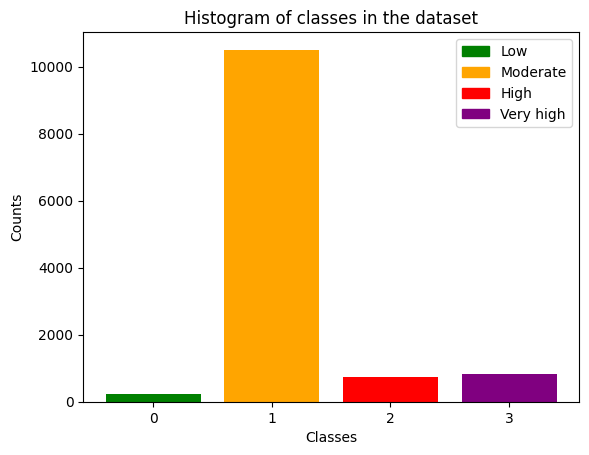

In [ ]:
# Create the histogram
# Define custom colors for the bars
bar_colors = ['green','orange','red','purple']
plt.bar(unique_values, value_counts, color=bar_colors)

# Define the labels for the legend
legend_labels = ['Low','Moderate','High','Very high']

# Create a list of Patch objects for the legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(bar_colors, legend_labels)]

# Add the legend
plt.legend(handles=legend_patches)

# Set labels and title
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Histogram of classes in the dataset')
plt.xticks([0,1,2,3])

# Display the plot
plt.show()

In [ ]:
extreme = dataset_scaled.query('categories == 3')['location_name'].value_counts()
extreme

Jakarta         63
New Delhi       49
Beijing         48
Kuala Lumpur    44
Islamabad       44
                ..
Djibouti         1
Tokyo            1
Gaborone         1
Algiers          1
Jerusalem        1
Name: location_name, Length: 72, dtype: int64

In [ ]:
extreme_categories = dataset_scaled.query('categories == 3')['location_name'].unique()
extreme_categories

array(['Luanda', 'Manama', 'Dhaka', 'Santiago', 'Guatemala City',
       'Jakarta', 'Maseru', 'Kuala Lumpur', 'Islamabad', 'Abu Dhabi',
       'Beijing', 'Kathmandu', 'Riyadh', 'Seoul', 'Addis Ababa', 'Hanoi',
       'Tehran', 'Paris', 'Mexico City', 'Doha', 'Algiers', 'Niamey',
       'Bangkok', 'Quito', 'Mbabane', 'New Delhi', 'Gaborone', 'Tokyo',
       'Djibouti', 'Ouagadougou', 'Phnom Penh', 'Kuwait City',
       'Pyongyang', 'Manila', 'Pretoria', 'Windhoek', 'Warsaw', 'Harare',
       'Cairo', 'Kampala', 'Norman Gardens', 'Asmara', 'Muscat',
       'Brazzaville', 'Kinshasa', 'Valletta', 'Nouakchott', "N'djamena",
       'Singapore', 'Caracas', 'Helsinki', 'Vatican City', 'Rome',
       'Khartoum', 'Ankara', 'Praia', 'Dakar', 'Juba', 'Sanaa',
       'San Marino', 'Antananarivo', 'Belgrade', 'Pathein', 'Lusaka',
       'Bamako', 'Budapest', 'Amman', 'Yaren', 'Bucharest', 'Colombo',
       'Baghdad', 'Jerusalem'], dtype=object)

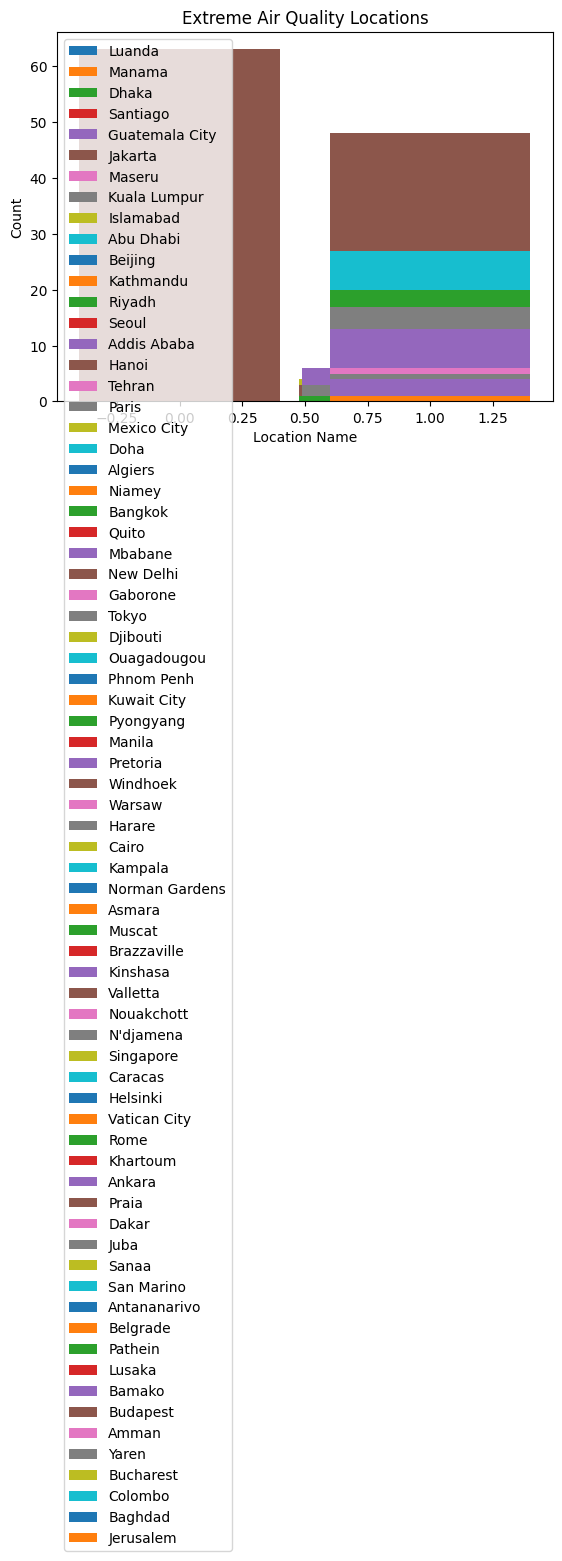

In [ ]:
for category in extreme_categories:
    extreme_by_category = dataset_scaled.query('categories == 3 and location_name == @category')['air_quality_gb-defra-index'].value_counts()
    plt.bar(extreme_by_category.index, extreme_by_category.values, label=category)

plt.xlabel('Location Name')
plt.ylabel('Count')
plt.title('Extreme Air Quality Locations')
plt.legend()
plt.show()

In [ ]:
# Evaluating the performance of different models
#Defining the function to split data for one step ahead
 # Split target and features from train and test
def create_dataset(dataset, look_back=1):
  X, Y, dates = [], [], []
  for location_name, group in dataset.groupby('location_name'):
    values = group.values
    for i in range(len(values)-look_back-1):
      a = values[i:(i+look_back), 1:]
      b = values[i+look_back, -1]
      date = values[i+look_back, 0]
      X.append(a)
      Y.append(b)
      dates.append(date)
  return np.array(X), np.array(Y), dates

# Restting index in the dataset for projection
dataset_reset = dataset_scaled.reset_index()

look_back=1
# PReparing data for one day ahead projection using the entiere dataset
Xtrain, ytrain, train_dates = create_dataset(dataset_reset, look_back)

# Evaluating the performance of different classifiers
def train_and_evaluate(Xtrain_reshaped, ytrain):
    # Initialize the classifiers
    classifiers = [
        LogisticRegression(),
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        XGBClassifier(),
        LGBMClassifier(),
        SVC()
    ]

    # Train and evaluate each classifier
    for classifier in classifiers:
        # Train the model
        classifier.fit(Xtrain_reshaped, ytrain)

        # Make predictions on the training set and calculate metrics
        ypred_train = classifier.predict(Xtrain_reshaped)
        accuracy_train = accuracy_score(ytrain, ypred_train)
        precision_train = precision_score(ytrain, ypred_train, average='weighted')
        recall_train = recall_score(ytrain, ypred_train, average='weighted')
        f1_train = f1_score(ytrain, ypred_train, average='weighted')

        # Perform 5-fold cross validation
        scores = cross_val_score(classifier, Xtrain_reshaped, ytrain, cv=5)

        # Print cross-validation scores and training set metrics
        print("Classifier:", classifier.__class__.__name__)
        print("Cross-validation scores: ", scores)
        print('Accuracy train:' ,accuracy_train)
        print('Precision train:', precision_train)
        print('Recall train:', recall_train)
        print('F1 score train:', f1_train)
        print()

# Reshaping the train
Xtrain_reshaped = Xtrain.reshape(Xtrain.shape[0],(Xtrain.shape[1]*Xtrain.shape[2]))

# Calling the train and evaluation function ignoring the first columns which is the item Id
train_and_evaluate(Xtrain_reshaped[:,1:], ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classifier: LogisticRegression
Cross-validation scores:  [0.88683214 0.88678451 0.87584175 0.88383838 0.88173401]
Accuracy train: 0.8844373369245013
Precision train: 0.8393830735766217
Recall train: 0.8844373369245013
F1 score train: 0.8478563985390563

Classifier: RandomForestClassifier
Cross-validation scores:  [0.88599074 0.89604377 0.89351852 0.87794613 0.87794613]
Accuracy train: 1.0
Precision train: 1.0
Recall train: 1.0
F1 score train: 1.0

Classifier: DecisionTreeClassifier
Cross-validation scores:  [0.80437526 0.81818182 0.8013468  0.81565657 0.81649832]
Accuracy train: 1.0
Precision train: 1.0
Recall train: 1.0
F1 score train: 1.0

Classifier: KNeighborsClassifier
Cross-validation scores:  [0.87336979 0.878367   0.87457912 0.87415825 0.87037037]
Accuracy train: 0.905563504755492
Precision train: 0.8879389193914278
Recall train: 0.905563504755492
F1 score train: 0.8904837821401915

Classifier: XGBClassifier
Cross-validation scores:  [0.88430795 0.88299663 0.88131313 0.87121212

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier: SVC
Cross-validation scores:  [0.88893563 0.89688552 0.89183502 0.88215488 0.88131313]
Accuracy train: 0.8931066408551469
Precision train: 0.868693385427675
Recall train: 0.8931066408551469
F1 score train: 0.8587687005074861



In [ ]:
# Making classification using the RandomForest algorithm, the best model
rf = RandomForestClassifier()
rf.fit(Xtrain_reshaped[:,1:], ytrain)

rfpred = rf.predict(Xtrain_reshaped[:,1:])

# Reshaping predictions
#rfpred_reshaped = rfpred.reshape(rfpred.shape[0],1)

# Metrics
MCC = matthews_corrcoef(ytrain, rfpred)
cr = classification_report(ytrain, rfpred)
cm = confusion_matrix(ytrain, rfpred)

print('Matthew corrcoeff:')
print(MCC)
print('Classification report:')
print(cr)
print('Confusion matrix:')
print(cm)
print()

Matthew corrcoeff:
1.0
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       219
           1       1.00      1.00      1.00     10167
           2       1.00      1.00      1.00       708
           3       1.00      1.00      1.00       787

    accuracy                           1.00     11881
   macro avg       1.00      1.00      1.00     11881
weighted avg       1.00      1.00      1.00     11881

Confusion matrix:
[[  219     0     0     0]
 [    0 10167     0     0]
 [    0     0   708     0]
 [    0     0     0   787]]



<Axes: >

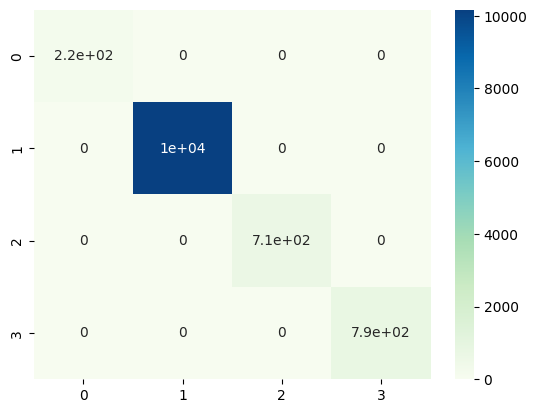

In [ ]:
sns.heatmap(cm, annot=True, cmap='GnBu')

In [ ]:
# Visualising the results of prediction

# Create a DataFrame to store the results
result_train = pd.DataFrame()

# Filter the data for the primaryItemId, actual, prediction, and date with length 17567
result_train['Date'] = train_dates
result_train['location_name'] = Xtrain_reshaped[:,:1][:len(ytrain)]
result_train['Actual'] = np.round(ytrain)
result_train['Prediction'] = np.round(rfpred)
result_train['Difference'] = result_train['Actual'] - result_train['Prediction']

# Print the first 20 elements of the result DataFrame
print(result_train)

# Print the mean NRMSE
print('Mean Error:', np.mean(result_train['Difference']))

             Date   location_name  Actual  Prediction  Difference
0      2023-08-30  'S-Gravenwezel       1           1           0
1      2023-08-31  'S-Gravenwezel       1           1           0
2      2023-09-01  'S-Gravenwezel       1           1           0
3      2023-09-02  'S-Gravenwezel       1           1           0
4      2023-09-03  'S-Gravenwezel       1           1           0
...           ...             ...     ...         ...         ...
11876  2023-10-24          Zagreb       1           1           0
11877  2023-10-25          Zagreb       1           1           0
11878  2023-10-26          Zagreb       1           1           0
11879  2023-10-27          Zagreb       1           1           0
11880  2023-10-28          Zagreb       1           1           0

[11881 rows x 5 columns]
Mean Error: 0.0


Trying the case of congo

In [ ]:
congo = dataset_scaled.query('location_name == "Kinshasa"')
congo

location_name  temperature_celsius  wind_mph  wind_degree  \
last_updated                                                             
2023-08-29        Kinshasa             0.836207  0.265625     0.749153   
2023-08-30        Kinshasa             0.224138  0.164062     0.779661   
2023-08-31        Kinshasa             0.448276  0.320312     0.810169   
2023-09-01        Kinshasa             0.387931  0.320312     0.850847   
2023-09-02        Kinshasa             0.396552  0.562500     0.847458   
...                    ...                  ...       ...          ...   
2023-10-25        Kinshasa             0.482759  0.460938     0.949153   
2023-10-26        Kinshasa             0.051724  1.000000     0.203390   
2023-10-27        Kinshasa             0.310345  0.367188     0.576271   
2023-10-28        Kinshasa             0.655172  0.000000     0.169492   
2023-10-29        Kinshasa             0.655172  0.000000     0.000000   

              wind_direction  pressure_mb  precip_mm  humidity     cloud  \
last_updated                                                               
2023-08-29          0.785714     0.777778   0.000000      0.12  0.689655   
2023-08-30          1.000000     0.666667   0.000000      0.68  0.000000   
2023-08-31          1.000000     0.333333   0.000000      0.12  0.091954   
2023-09-01          0.857143     0.333333   0.000000      0.10  0.183908   
2023-09-02          0.857143     0.666667   0.000000      0.42  0.000000   
...                      ...          ...        ...       ...       ...   
2023-10-25          0.928571     0.333333   0.084270      0.52  0.000000   
2023-10-26          0.000000     1.000000   0.000000      1.00  0.862069   
2023-10-27          0.500000     0.555556   0.000000      1.00  0.287356   
2023-10-28          0.000000     0.222222   0.039326      0.36  0.000000   
2023-10-29          0.142857     0.000000   0.000000      0.52  0.287356   

              feels_like_celsius  ...  uv_index  gust_mph  \
last_updated                      ...                       
2023-08-29              0.705882  ...       1.0  0.471545   
2023-08-30              0.247059  ...       0.0  0.617886   
2023-08-31              0.341176  ...       0.0  0.886179   
2023-09-01              0.294118  ...       0.0  0.926829   
2023-09-02              0.294118  ...       0.0  0.943089   
...                          ...  ...       ...       ...   
2023-10-25              0.570588  ...       0.0  0.707317   
2023-10-26              0.182353  ...       0.0  0.504065   
2023-10-27              0.347059  ...       0.0  0.235772   
2023-10-28              0.741176  ...       0.0  0.317073   
2023-10-29              0.676471  ...       0.0  0.252033   

              air_quality_Carbon_Monoxide  air_quality_Ozone  \
last_updated                                                   
2023-08-29                       0.119977           0.770459   
2023-08-30                       0.279994           0.371257   
2023-08-31                       0.209432           0.642715   
2023-09-01                       0.119977           0.542914   
2023-09-02                       0.317637           1.000000   
...                                   ...                ...   
2023-10-25                       0.016495           0.145709   
2023-10-26                       0.018821           0.161677   
2023-10-27                       0.642323           0.000000   
2023-10-28                       0.510574           0.000000   
2023-10-29                       0.538841           0.000000   

              air_quality_Nitrogen_dioxide  air_quality_Sulphur_dioxide  \
last_updated                                                              
2023-08-29                        0.032258                     0.179487   
2023-08-30                        0.138249                     0.076923   
2023-08-31                        0.041475                     0.000000   
2023-09-01                        0.009217                 

In [ ]:
# counting items in the assumptions classes
unique_values, value_counts = np.unique(congo['categories'].values, return_counts=True)
unique_values, value_counts

(array([0, 1, 2, 3]), array([ 2, 53,  7,  1]))

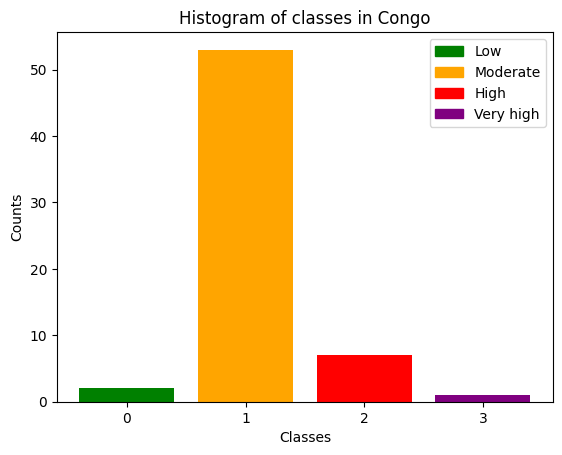

In [ ]:
# Create the histogram
# Define custom colors for the bars
bar_colors = ['green','orange','red','purple']
plt.bar(unique_values, value_counts, color=bar_colors)

# Define the labels for the legend
legend_labels = ['Low','Moderate','High','Very high']

# Create a list of Patch objects for the legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(bar_colors, legend_labels)]

# Add the legend
plt.legend(handles=legend_patches)

# Set labels and title
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Histogram of classes in Congo')
plt.xticks([0, 1, 2, 3])

# Display the plot
plt.show()

In [ ]:
# Ensuring that index is of type datetime
congo.index = pd.to_datetime(congo.index)

# Selecting the date before the last date
info = congo.loc['2023-10-28']
info_df = pd.DataFrame(info).transpose()
info_df

location_name temperature_celsius wind_mph wind_degree  \
2023-10-28      Kinshasa            0.655172      0.0    0.169492   

           wind_direction pressure_mb precip_mm humidity cloud  \
2023-10-28            0.0    0.222222  0.039326     0.36   0.0   

           feels_like_celsius  ... uv_index  gust_mph  \
2023-10-28           0.741176  ...      0.0  0.317073   

           air_quality_Carbon_Monoxide air_quality_Ozone  \
2023-10-28                    0.510574               0.0   

           air_quality_Nitrogen_dioxide air_quality_Sulphur_dioxide  \
2023-10-28                     0.506912                    0.461538   

           air_quality_PM2.5 air_quality_PM10 air_quality_gb-defra-index  \
2023-10-28           0.45625         0.867065                   0.333333   

           categories  
2023-10-28          2  

[1 rows x 21 columns]

In [ ]:
congo['categories'].unique()

array([1, 2, 3, 0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


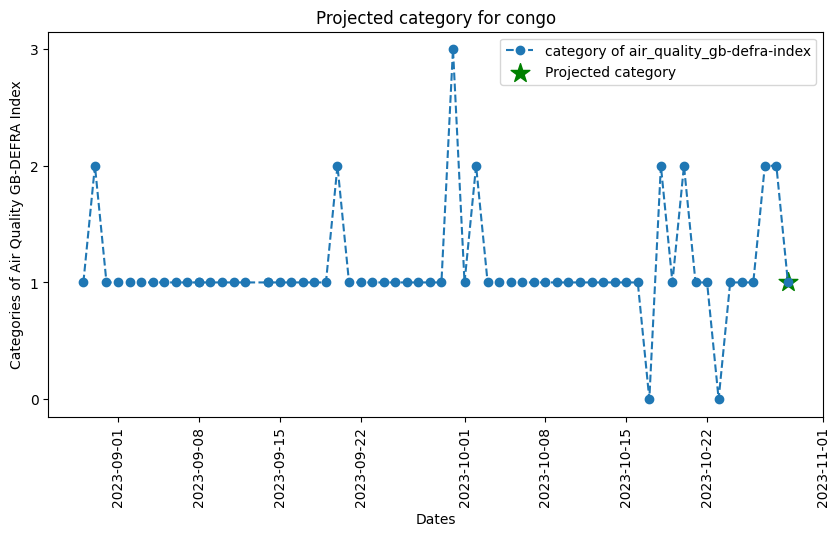

In [ ]:
# Making predction
prediction_congo = rf.predict(info_df.iloc[:,1:])

#indices = [congo.loc['2023-10-27'].name, congo.loc['2023-10-28'].name]
prediction_congo_df = pd.DataFrame(prediction_congo, index = [congo.loc['2023-10-29'].name] , columns=['projected category'])
prediction_congo_df

plt.figure(figsize=(10,5))
plt.plot(congo['categories'], label='category of air_quality_gb-defra-index', ls='--', marker='o')
plt.scatter(prediction_congo_df.index, prediction_congo_df['projected category'], color='green', label = 'Projected category', marker='*', s=200)
plt.title('Projected category for congo')
plt.ylabel('Categories of Air Quality GB-DEFRA Index')
plt.xlabel('Dates')
plt.legend()
# Set y-axis to show only categories 0, 1, 2, 3
plt.yticks([0, 1, 2, 3])
plt.xticks(rotation = 90);

In [ ]:
prediction_congo_df

projected category
2023-10-29                   1

In [ ]:
# Ensuring that index is of type datetime
congo.index = pd.to_datetime(congo.index)

# Selecting the date before the last date
info = congo.loc['2023-10-29']
info_df = pd.DataFrame(info).transpose()
info_df

location_name temperature_celsius wind_mph wind_degree  \
2023-10-29      Kinshasa            0.655172      0.0         0.0   

           wind_direction pressure_mb precip_mm humidity     cloud  \
2023-10-29       0.142857         0.0       0.0     0.52  0.287356   

           feels_like_celsius  ... uv_index  gust_mph  \
2023-10-29           0.676471  ...      0.0  0.252033   

           air_quality_Carbon_Monoxide air_quality_Ozone  \
2023-10-29                    0.538841               0.0   

           air_quality_Nitrogen_dioxide air_quality_Sulphur_dioxide  \
2023-10-29                     0.207373                    0.692308   

           air_quality_PM2.5 air_quality_PM10 air_quality_gb-defra-index  \
2023-10-29           0.40375         0.839466                   0.222222   

           categories  
2023-10-29          1  

[1 rows x 21 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
<ipython-input-33-63f469a7d7a7>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_congo_df = prediction_congo_df.append(new_data)


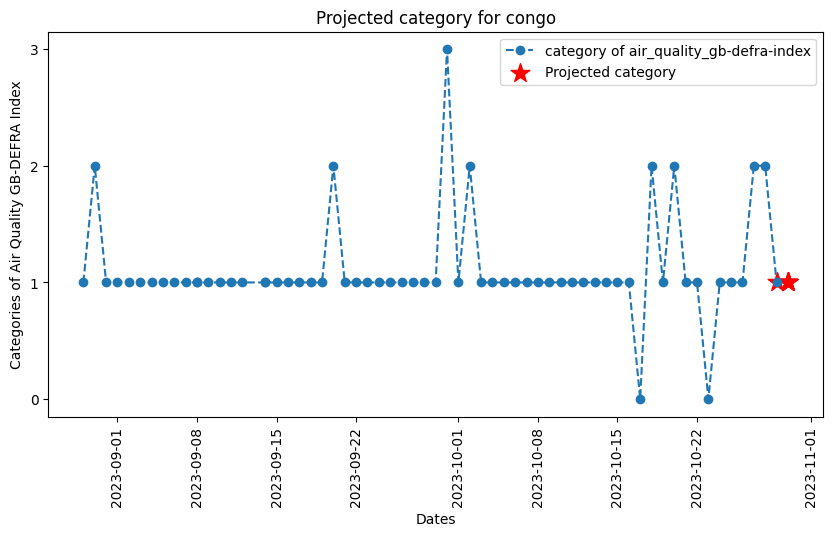

In [ ]:
# Making predction
prediction_congo = rf.predict(info_df.iloc[:,1:])

# Create a new DataFrame with the projection
new_data = pd.DataFrame({'projected category': [prediction_congo]}, index=pd.to_datetime(['2023-10-30']))

# Append the new data to your existing DataFrame
prediction_congo_df = prediction_congo_df.append(new_data)

# Plotting the result
plt.figure(figsize=(10,5))
plt.plot(congo['categories'], label='category of air_quality_gb-defra-index', ls='--', marker='o')
plt.scatter(prediction_congo_df.index, prediction_congo_df['projected category'], color='red', label = 'Projected category', marker='*', s=200)
plt.title('Projected category for congo')
plt.ylabel('Categories of Air Quality GB-DEFRA Index')
plt.xlabel('Dates')
plt.legend()
# Set y-axis to show only categories 0, 1, 2, 3
plt.yticks([0, 1, 2, 3])
plt.xticks(rotation = 90);

In [ ]:
prediction_congo

array([1])

In [ ]:
! pip install lime
import lime
from lime import lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fa8a2ad76a1052dee8de1509581d0988a300278d3c8aa96833a336886e19da2b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Define feature names and class names
feature_names = ['temperature_celsius', 'wind_mph','wind_degree', 'wind_direction', 'pressure_mb', 'precip_mm', 'humidity','cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_mph',
                 'air_quality_Carbon_Monoxide', 'air_quality_Ozone','air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide','air_quality_PM2.5', 'air_quality_PM10', 'air_quality_gb-defra-index',
                 'categories']
class_names = ['Low', 'Moderate','High', 'Very High']

# Create the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(dataset_reset.iloc[:,2:].values, feature_names=feature_names, class_names=class_names, mode='classification')

# Define the predict function for XGBoost
def predict_function(X):
    return rf.predict_proba(X)

# Get a single instance from the DataFrame
instance = assumptions_df.iloc[0,2:].values

# Explain the prediction of the instance
explanation = explainer.explain_instance(instance, predict_function, num_features=20)

# Print the explanation
print("Explanation for instance 1")
print("Prediction probabilities:")
print(explanation.predict_proba)

# Apply the threshold manually for each class
class_names_1 = ['Very good', 'Moderate', 'Warning','Very bad']
for i, class_name in enumerate(class_names_1):
    prediction = explanation.predict_proba[i]  # Probability of each class
    if prediction >= 0.5:
        print(f"Prediction: {class_name} air quality")
    else:
        print(f"No alarm for {class_name} air quality")

print("Feature importance:")
for feature, importance in explanation.as_list():
    print(feature, importance)
explanation.show_in_notebook()

Explanation for instance 1
Prediction probabilities:
[0.04 0.73 0.14 0.09]
No alarm for Very good air quality
Prediction: Moderate air quality
No alarm for Warning air quality
No alarm for Very bad air quality
Feature importance:
categories <= 1.00 0.3595707343525
air_quality_gb-defra-index > 0.22 -0.2695006276403627
air_quality_PM2.5 > 0.35 0.04588075055518391
feels_like_celsius <= 0.27 -0.0279102623275051
air_quality_Carbon_Monoxide > 0.40 0.027675105782018785
cloud > 0.67 0.021304948340828456
air_quality_Ozone > 0.52 0.0106448181410985
wind_degree > 0.72 -0.00901984624787587
uv_index > 0.00 0.006980268762246791
air_quality_Nitrogen_dioxide > 0.35 -0.005286418062068518
precip_mm > 0.00 -0.004765747683793322
temperature_celsius > 0.67 -0.0037069426300857296
gust_mph > 0.56 -0.0029475253358108187
humidity > 0.79 -0.0022756903086672228
wind_mph > 0.46 -0.0022087679409479063
wind_direction <= 0.20 0.0018469590037668738
pressure_mb > 0.73 0.0011358299473683698
0.75 < visibility_km <= 1.00

In [ ]:
!pip install eli5
import eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=d85e38fb061ac72443befccfe080b58d9c5d7c3fe6e78b22018d6cc7aadbc0fc
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
eli5.show_weights(rf, feature_names=feature_names)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
congo.columns

Index(['location_name', 'temperature_celsius', 'wind_mph', 'wind_degree',
       'wind_direction', 'pressure_mb', 'precip_mm', 'humidity', 'cloud',
       'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_mph',
       'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
       'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
       'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_gb-defra-index',
       'categories'],
      dtype='object')

Partial Dependence Plots for class 0:


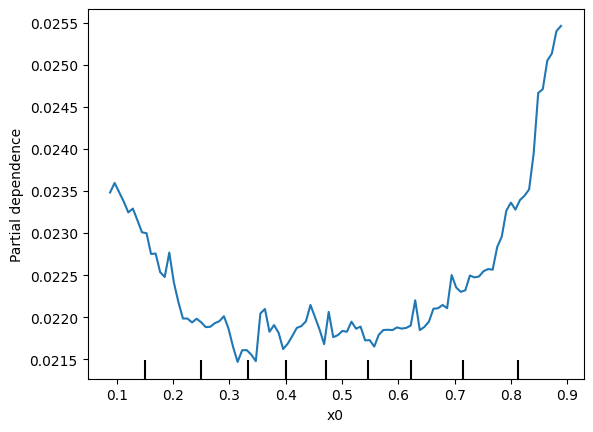

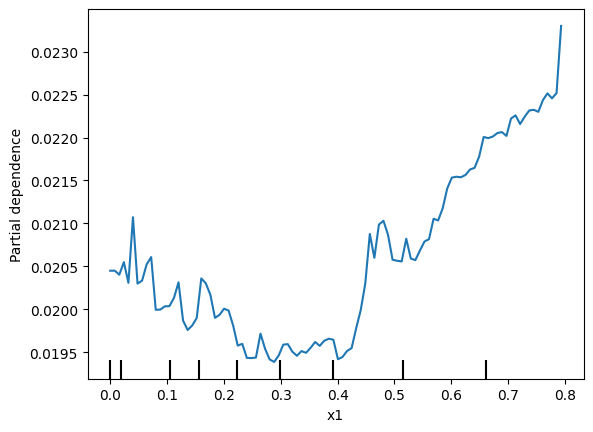

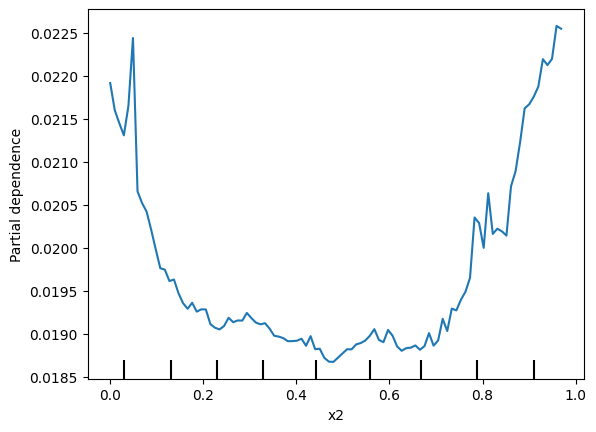

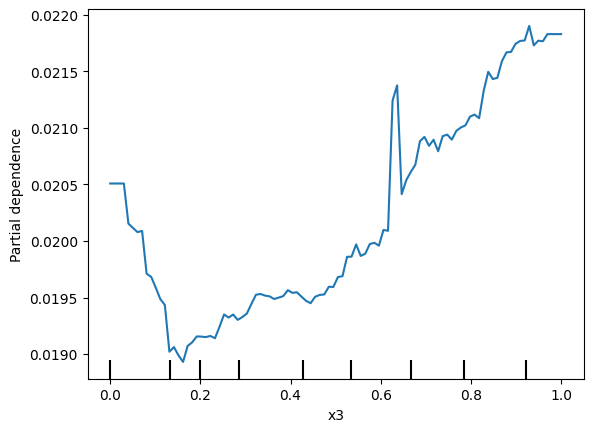

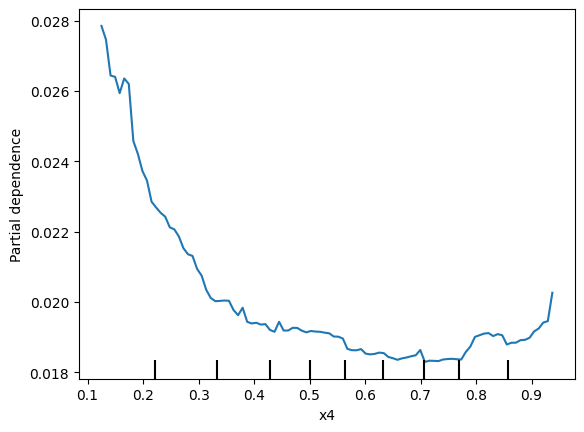

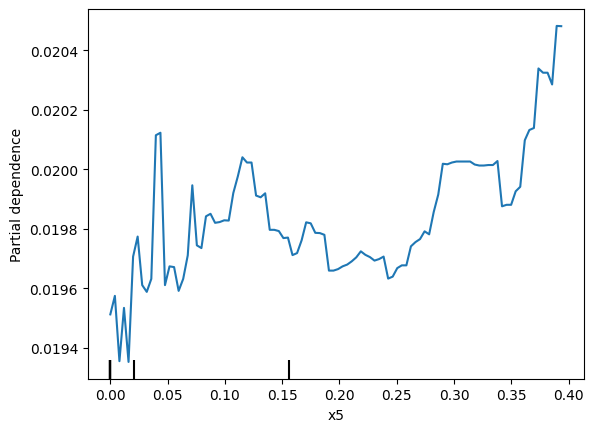

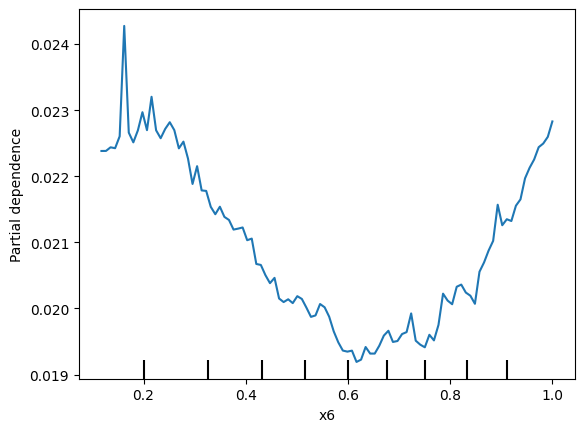

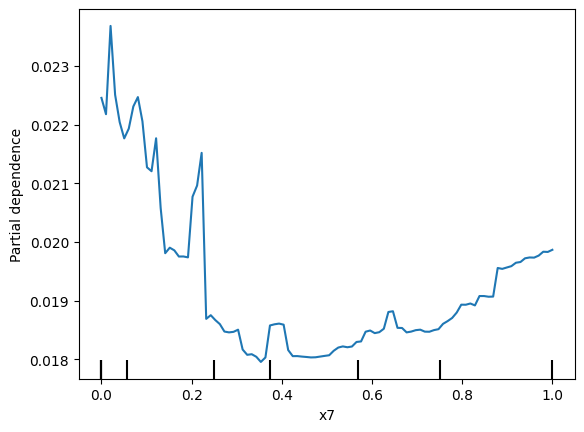

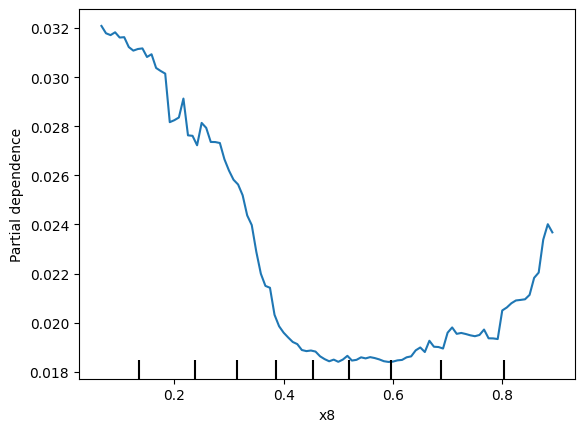

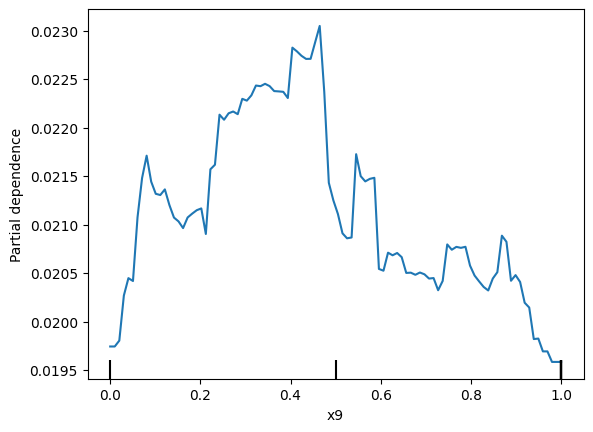

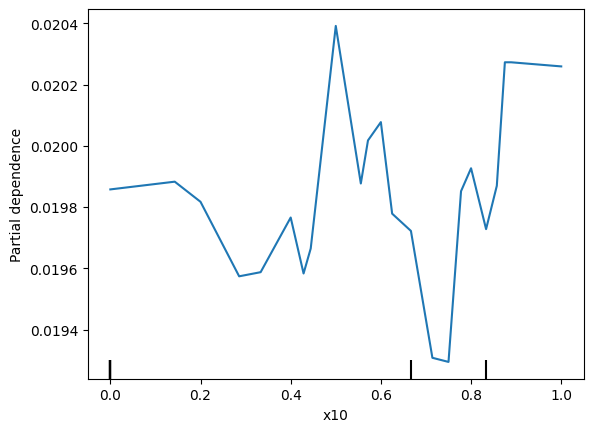

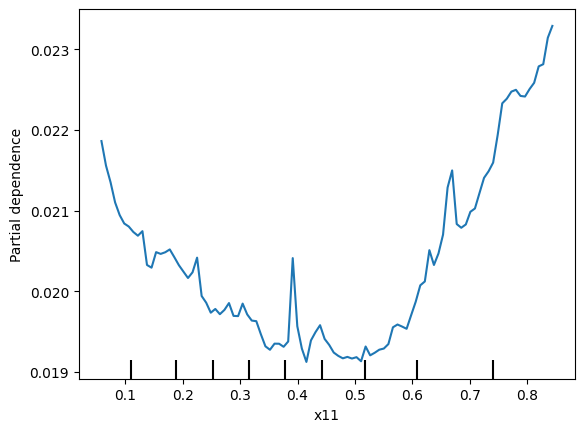

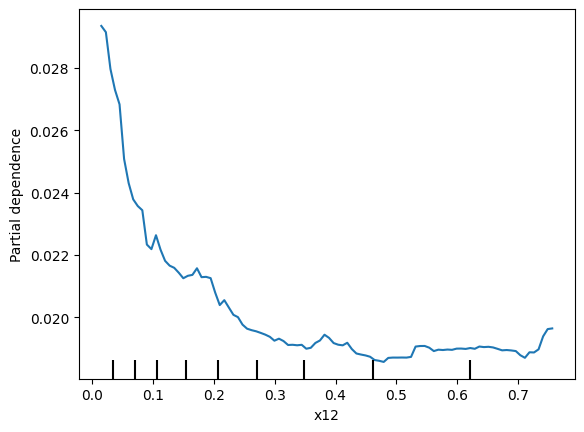

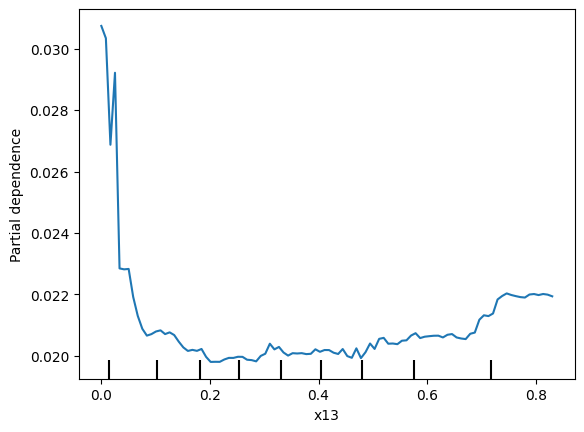

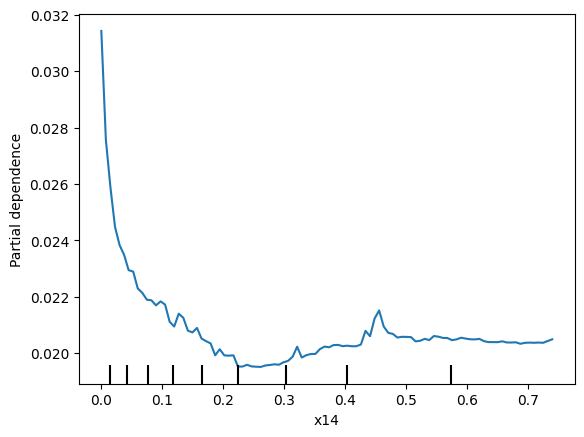

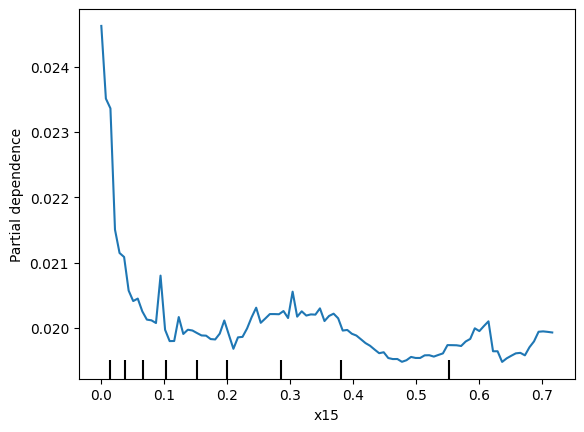

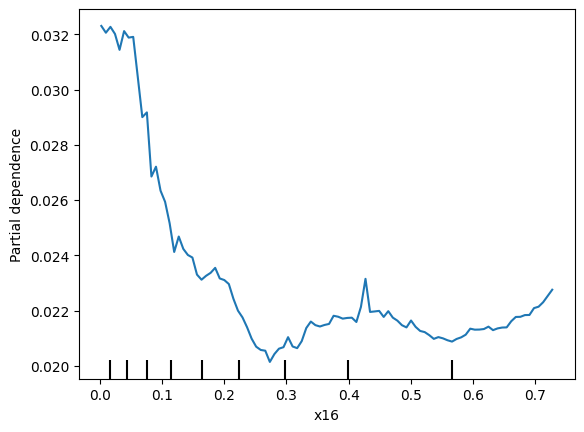

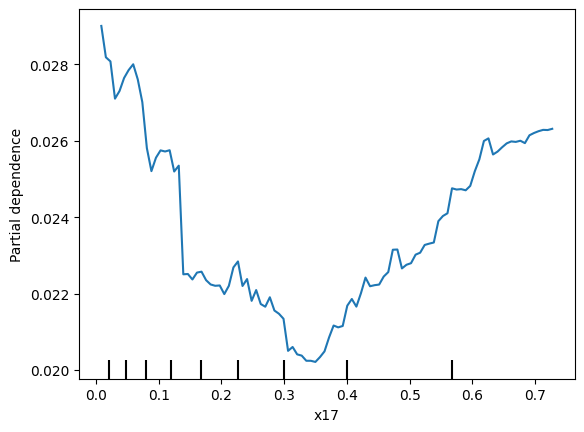

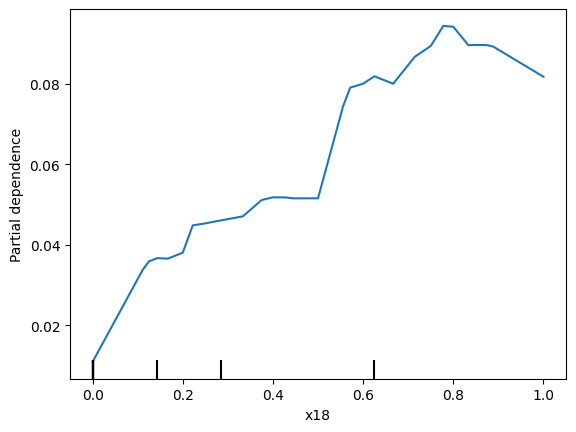

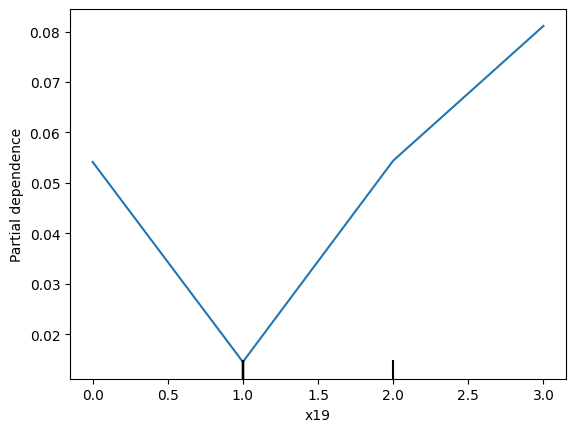

Partial Dependence Plots for class 1:


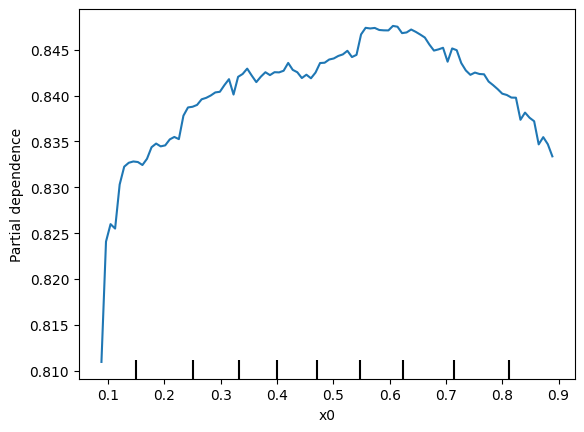

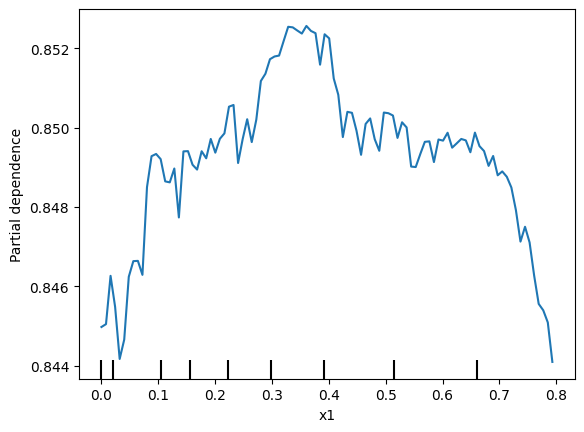

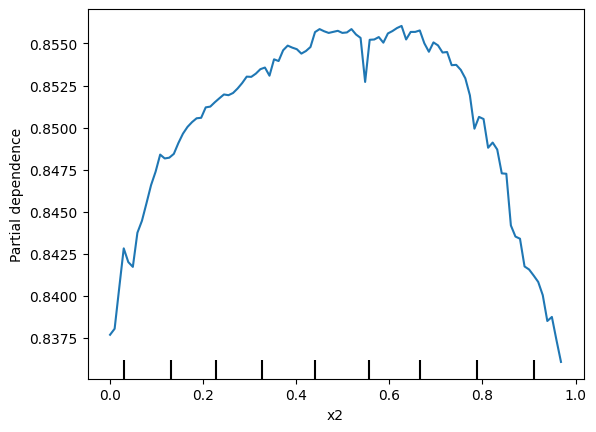

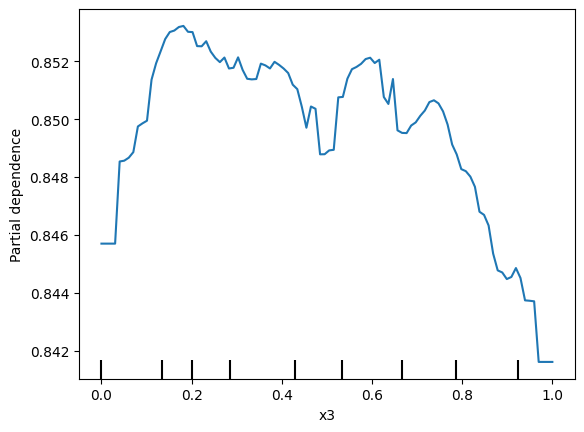

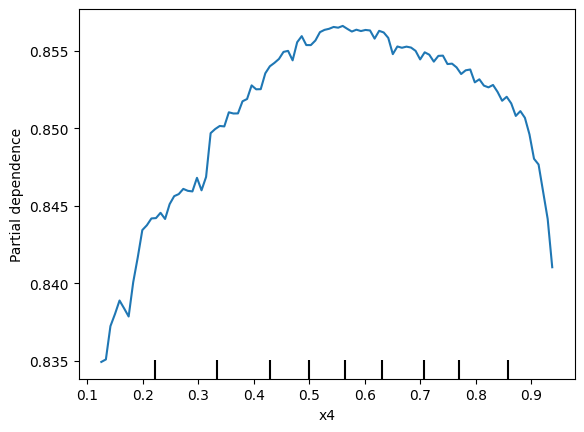

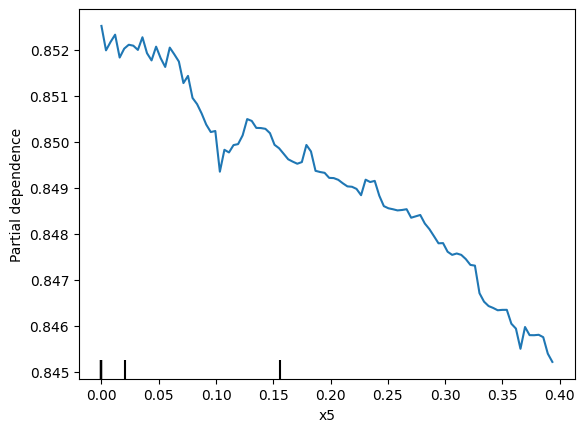

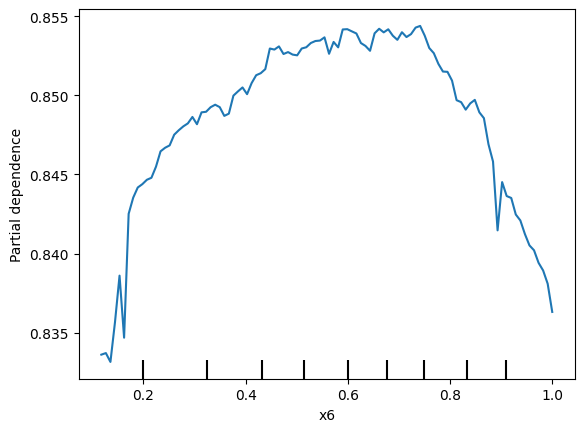

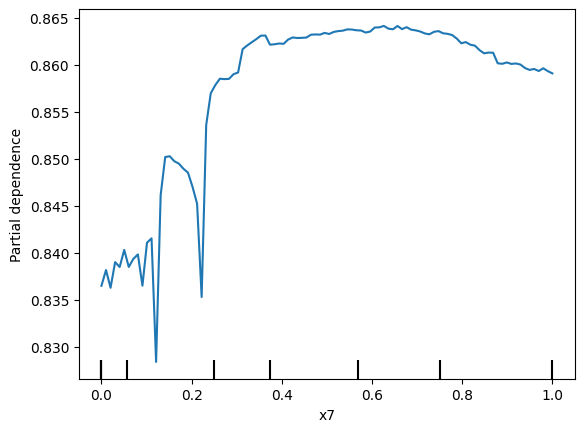

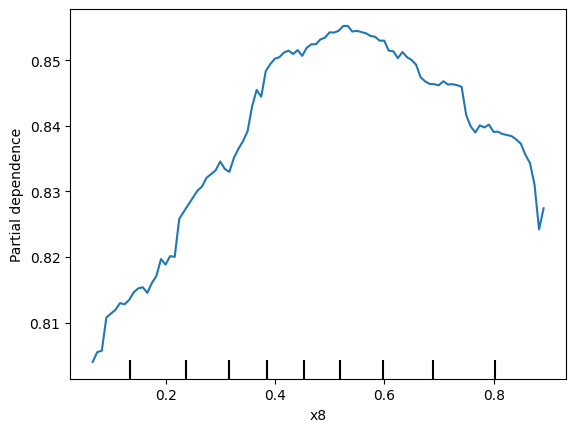

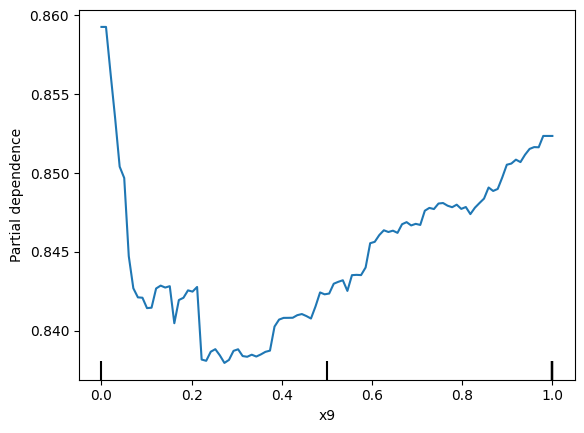

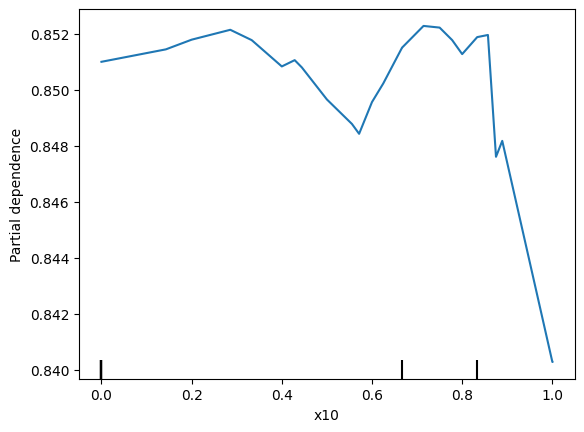

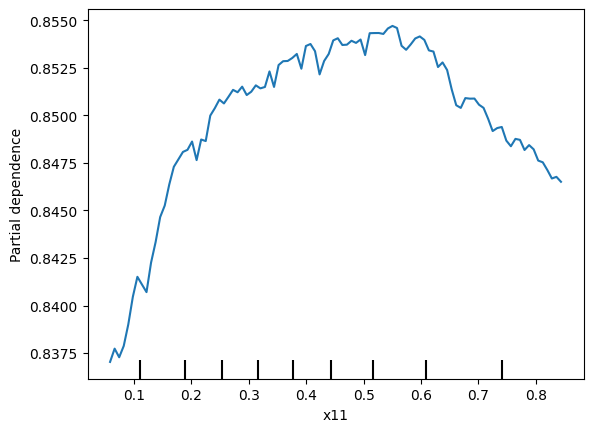

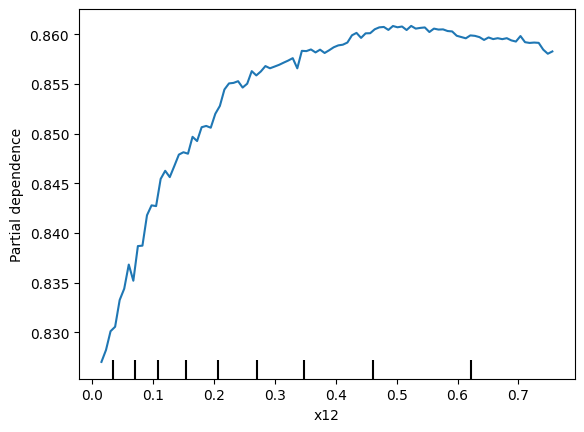

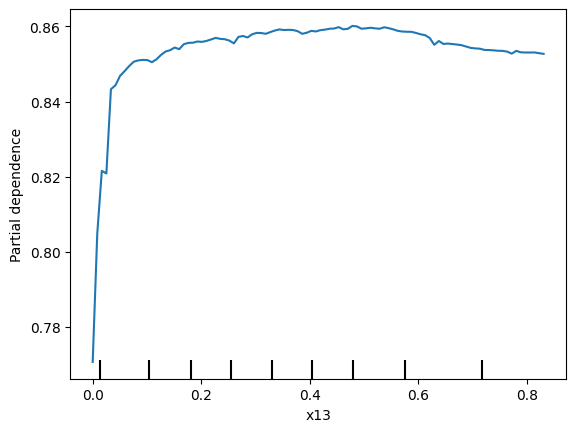

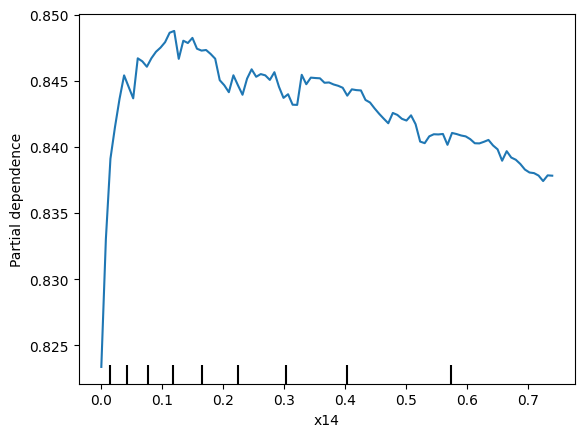

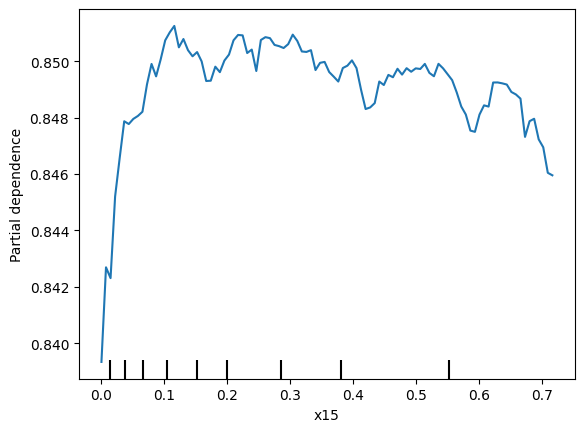

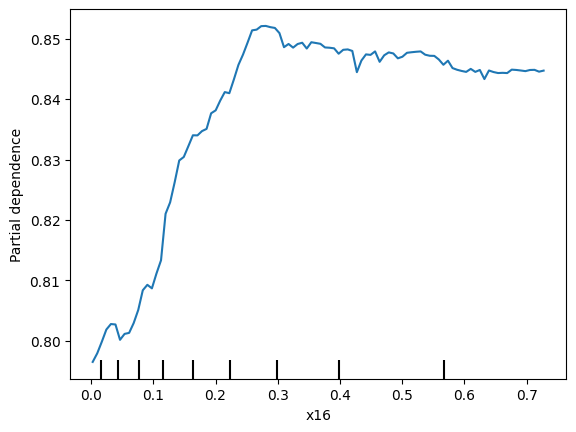

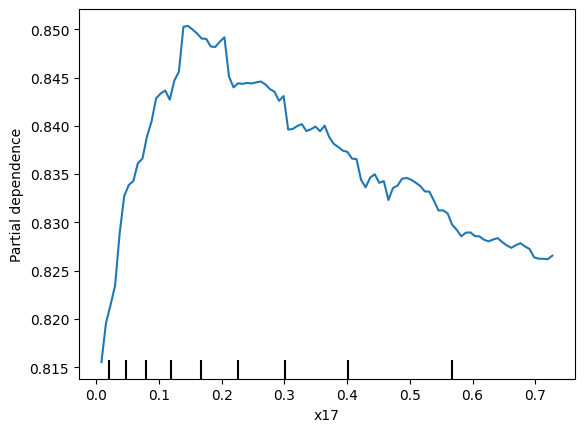

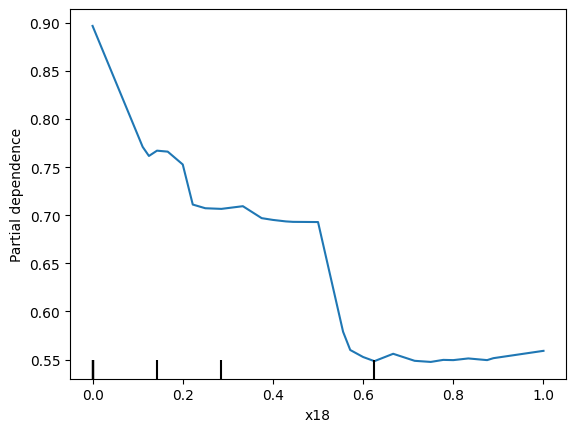

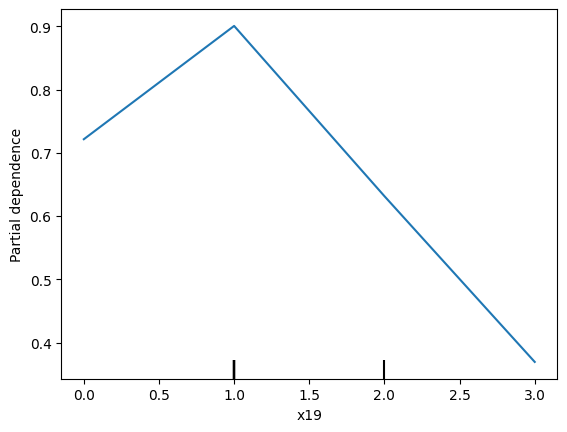

Partial Dependence Plots for class 2:


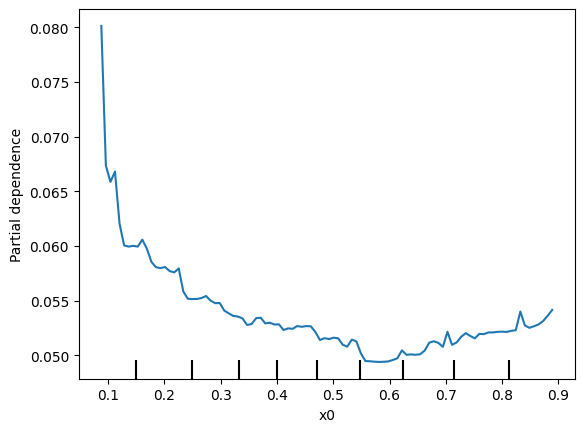

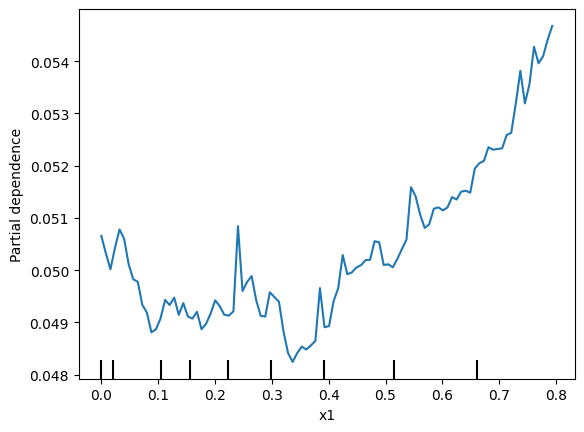

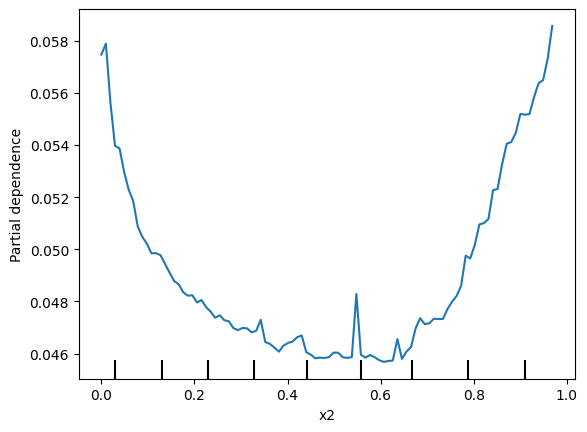

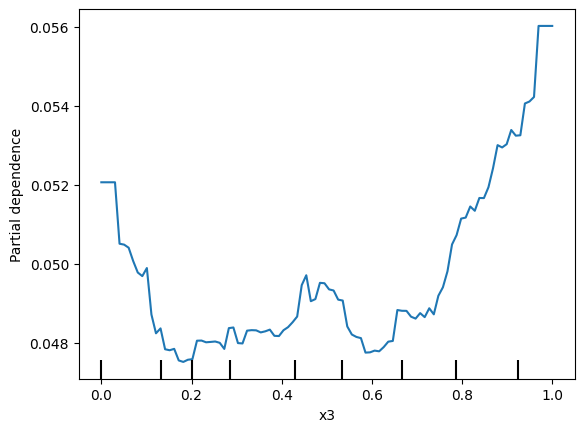

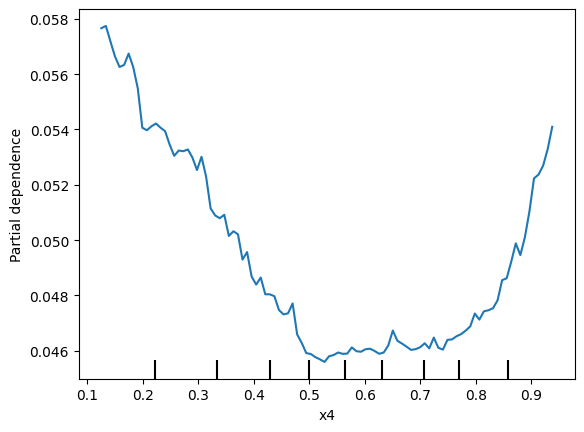

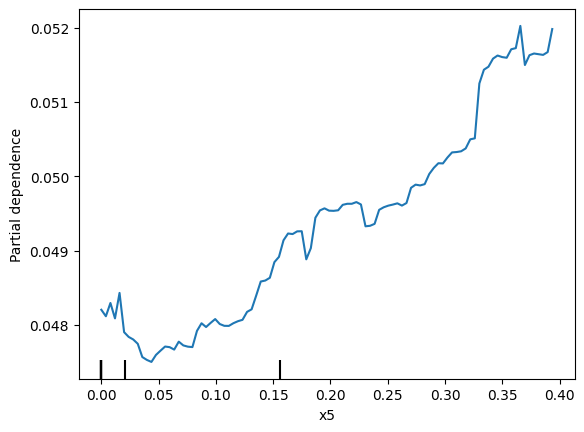

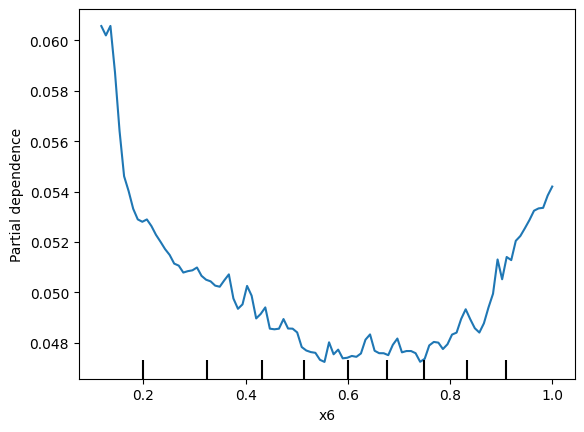

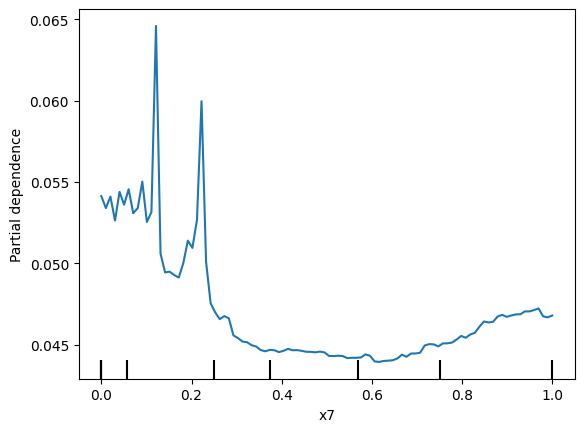

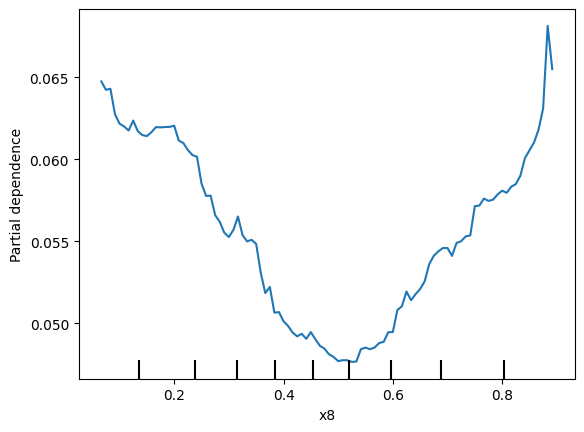

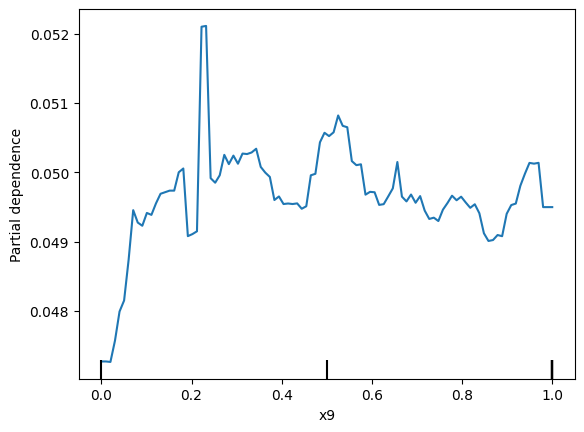

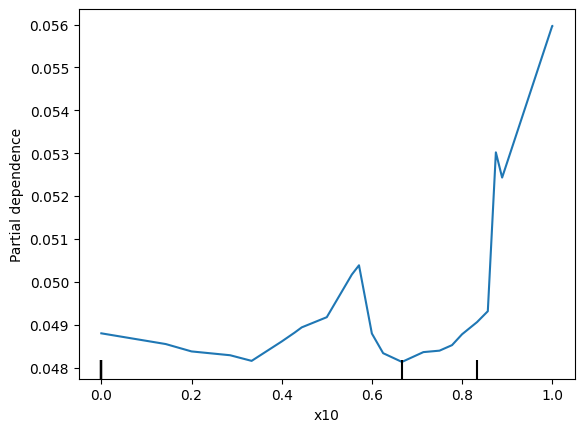

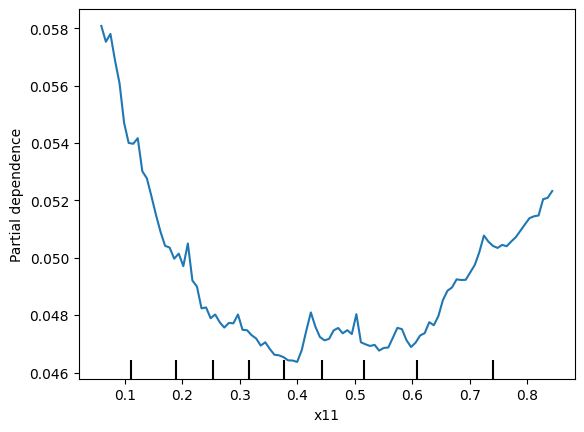

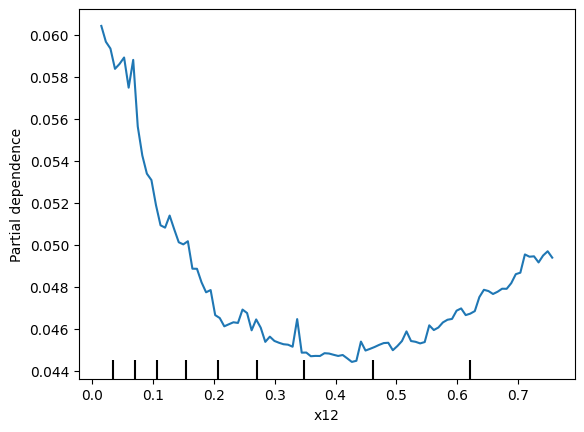

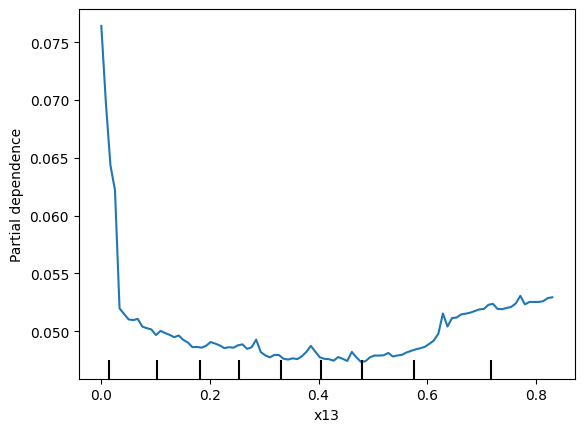

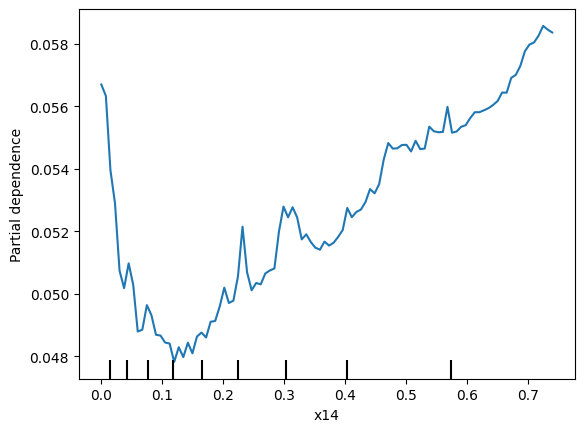

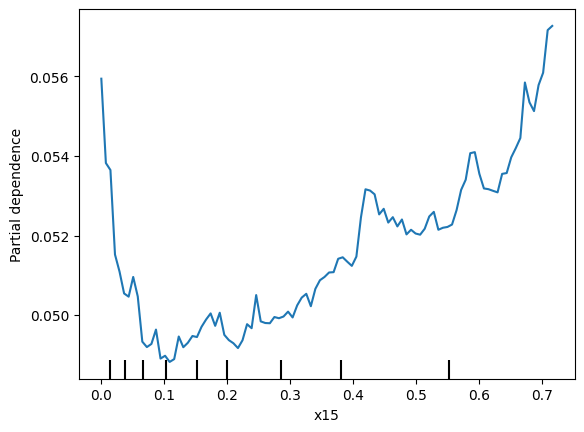

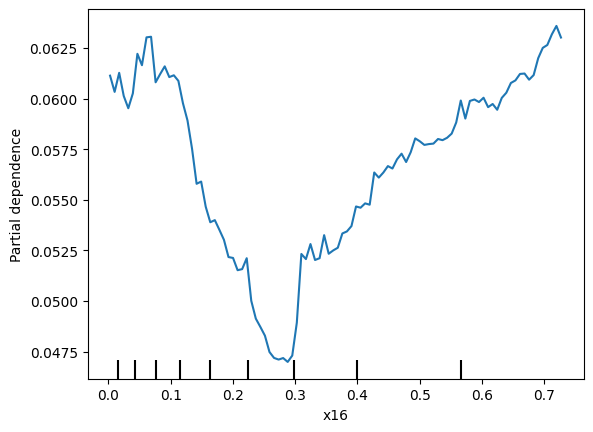

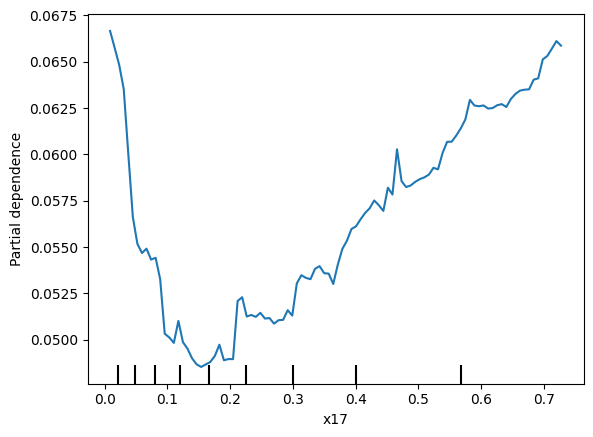

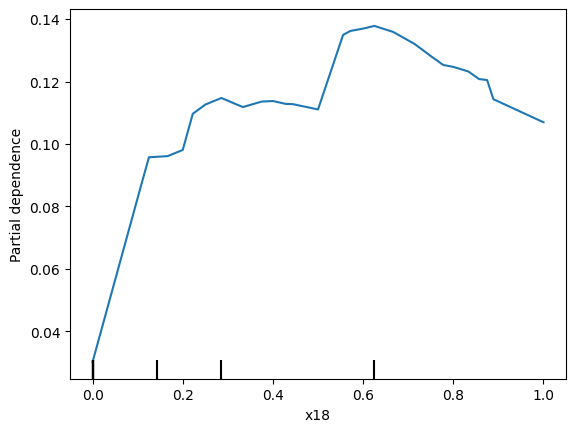

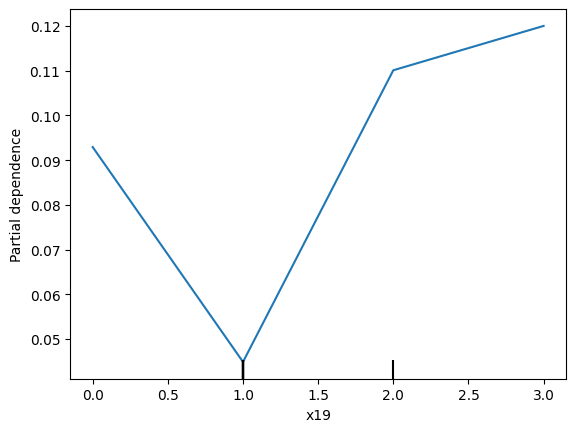

Partial Dependence Plots for class 3:


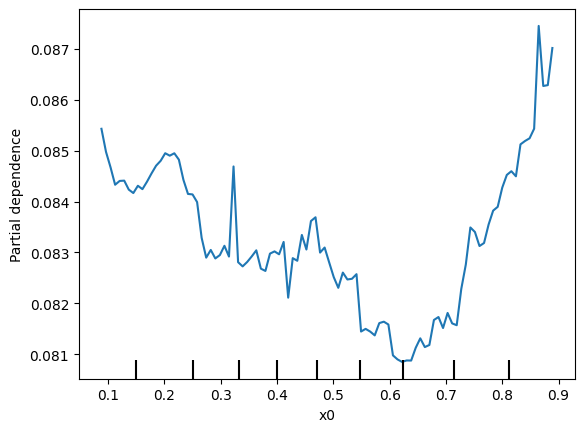

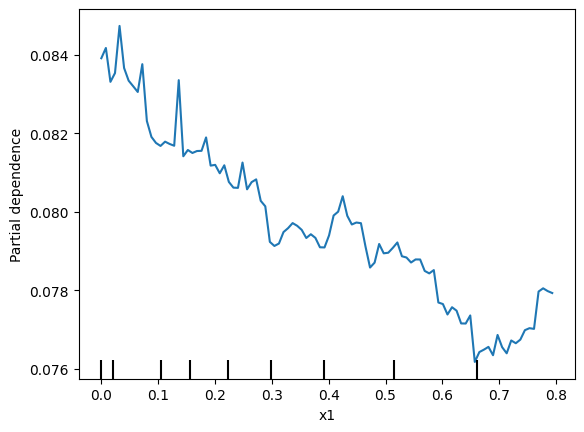

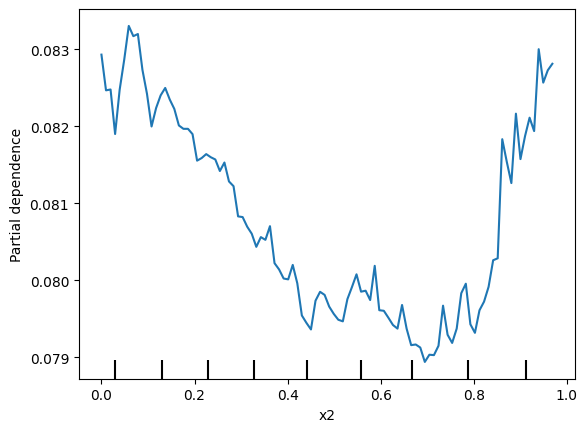

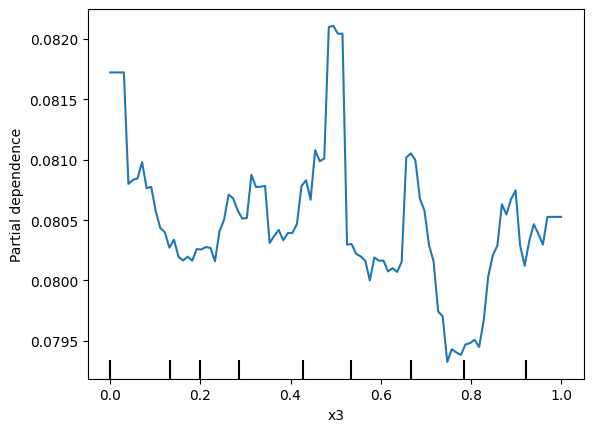

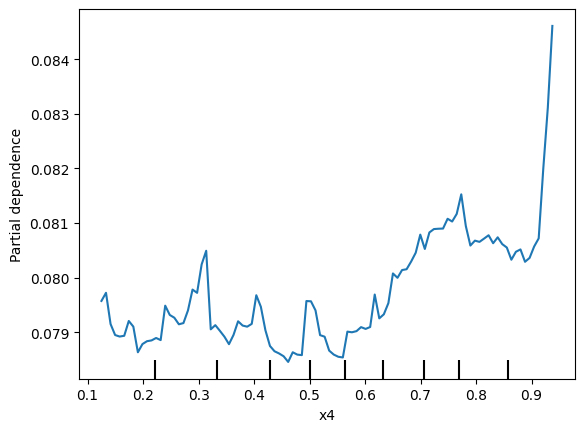

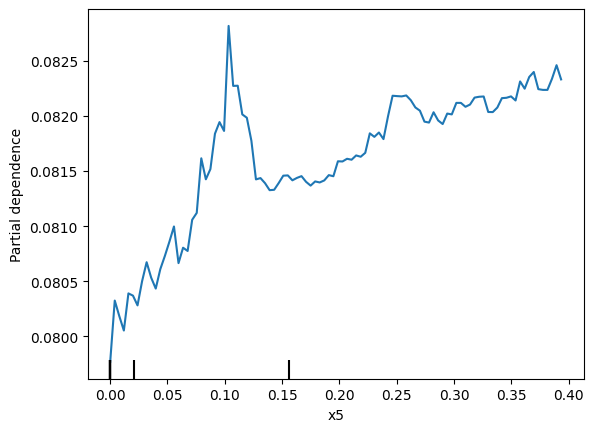

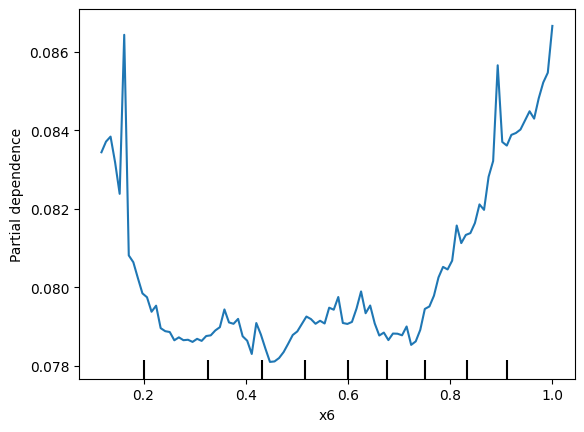

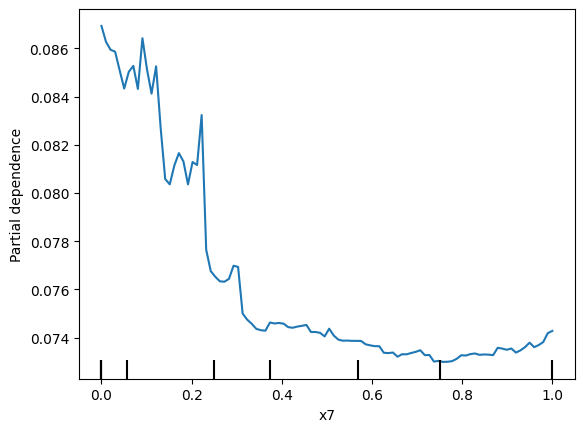

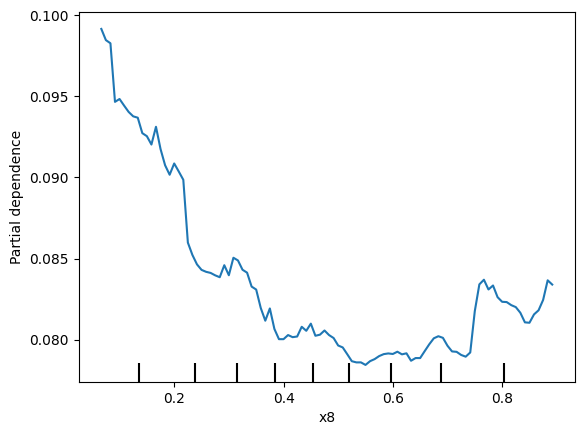

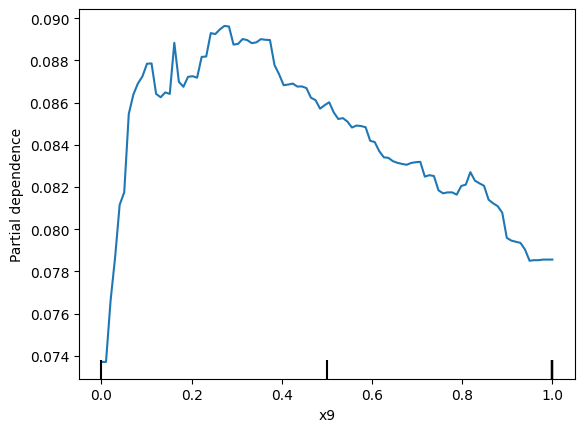

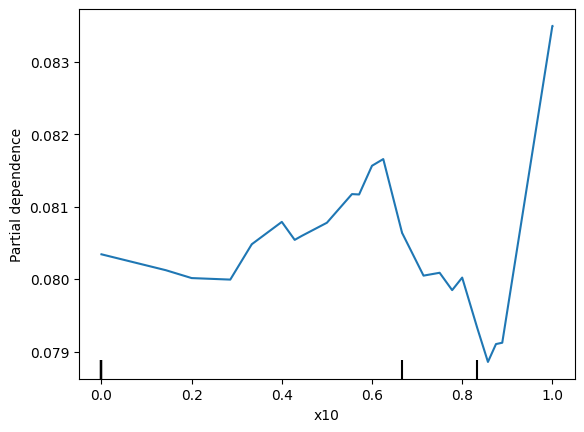

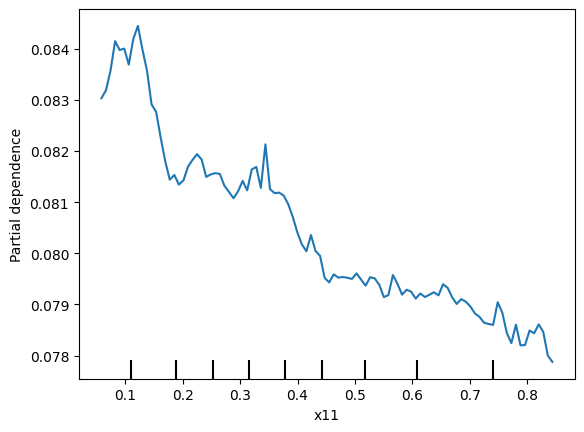

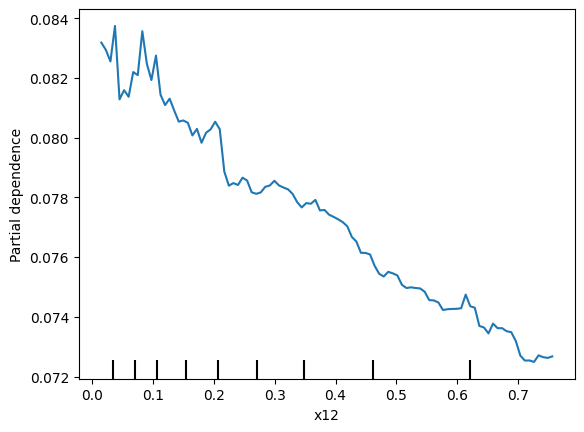

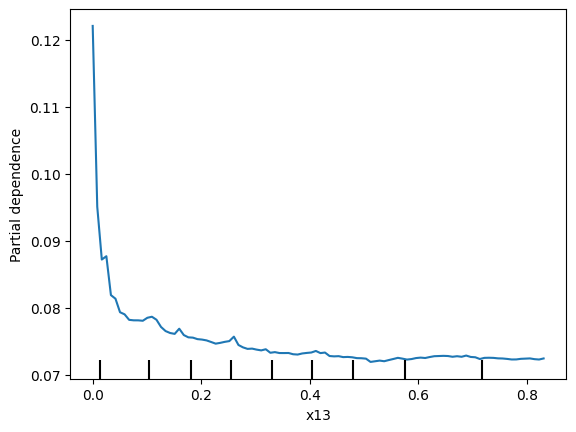

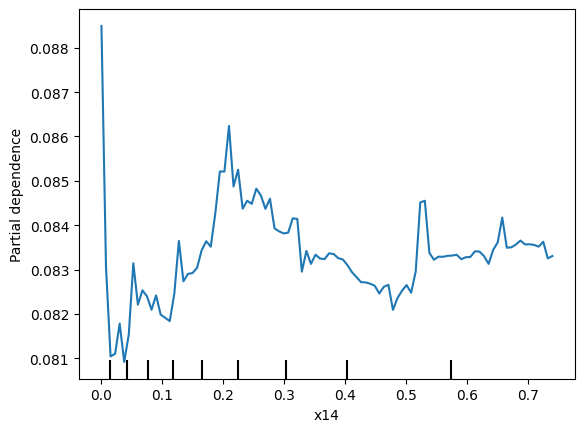

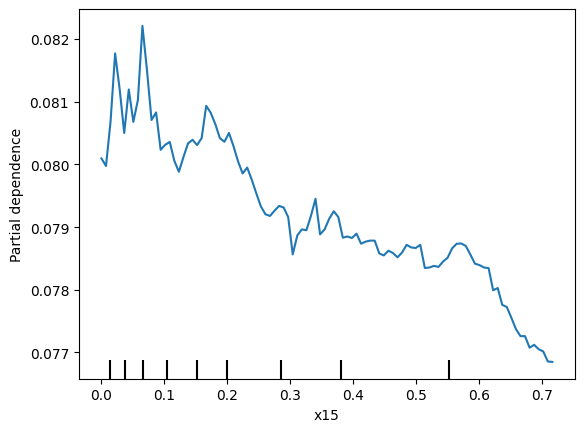

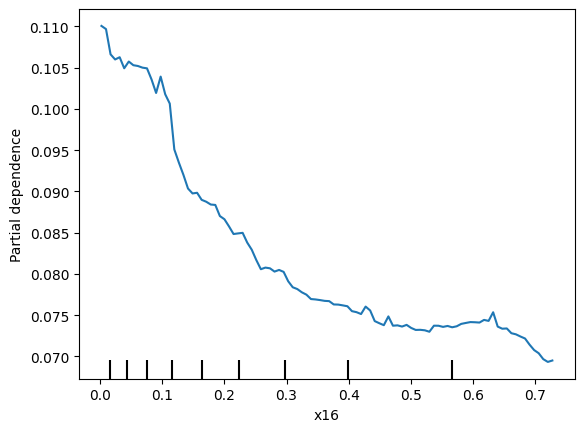

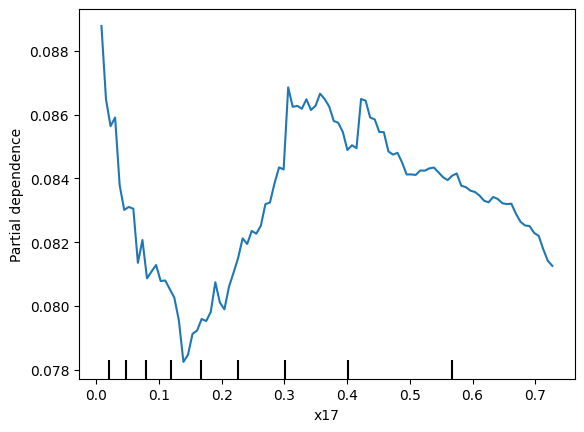

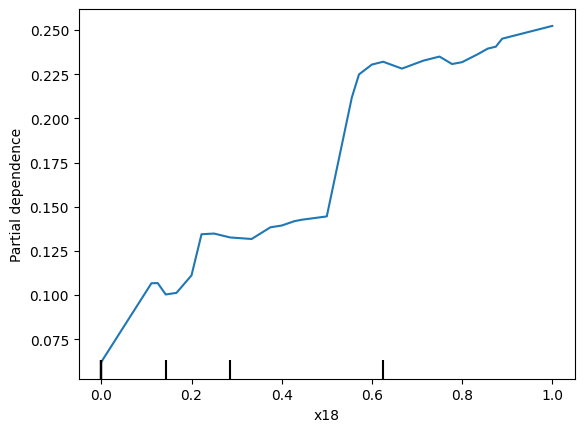

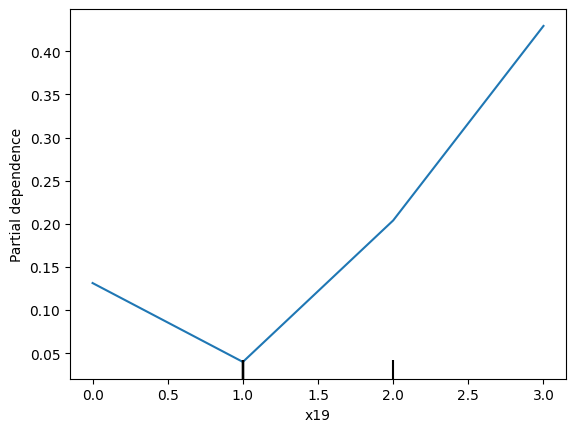

In [ ]:
# Train a Random Forest model
clf = RandomForestClassifier().fit(Xtrain_reshaped[:,1:], ytrain)

# Specify the target classes
target_classes = [0, 1, 2, 3]

for target_class in target_classes:
    print(f"Partial Dependence Plots for class {target_class}:")
    for i in range(len(feature_names)):
        disp = PartialDependenceDisplay.from_estimator(clf, Xtrain_reshaped[:,1:], [i], target=target_class)
        plt.show()